# CS480 Project

In [1]:
!unzip cs-480-2024-spring.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train_images/196207162.jpeg  
  inflating: data/train_images/196207164.jpeg  
  inflating: data/train_images/196207198.jpeg  
  inflating: data/train_images/196207403.jpeg  
  inflating: data/train_images/196207539.jpeg  
  inflating: data/train_images/196207572.jpeg  
  inflating: data/train_images/196207729.jpeg  
  inflating: data/train_images/196207888.jpeg  
  inflating: data/train_images/196208355.jpeg  
  inflating: data/train_images/196208682.jpeg  
  inflating: data/train_images/196208848.jpeg  
  inflating: data/train_images/196209074.jpeg  
  inflating: data/train_images/196209078.jpeg  
  inflating: data/train_images/196209236.jpeg  
  inflating: data/train_images/196209887.jpeg  
  inflating: data/train_images/196209889.jpeg  
  inflating: data/train_images/196209960.jpeg  
  inflating: data/train_images/196210323.jpeg  
  inflating: data/train_images/196211220.jpeg  
  inflating: data/train_images/196211

Load data

In [2]:
import os

train_images_count = len(os.listdir('data/train_images'))
test_images_count = len(os.listdir('data/test_images'))

print(f"Number of files in data/train_images: {train_images_count}")
print(f"Number of files in data/test_images: {test_images_count}")


Number of files in data/train_images: 43363
Number of files in data/test_images: 6391


In [3]:
import pandas as pd

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Shape of train.csv: {train_df.shape}")
print(f"Shape of test.csv: {test_df.shape}")


Shape of train.csv: (43363, 170)
Shape of test.csv: (6391, 164)


# Import data


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
# Load train.csv and test.csv
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_targets = train_df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']].values
train_data = train_df.iloc[:, 1:164].values
test_data = test_df.iloc[:, 1:164].values

train_ids = train_df['id'].values
test_ids = test_df['id'].values

# Normalize the data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

train_data = torch.tensor(train_data, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)



# Transformation

In [7]:
class PlantDataset(Dataset):
    def __init__(self, ids, data, targets=None, image_folder=None, transform=None):
        self.ids = ids
        self.data = data
        self.targets = targets
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ancillary_data = self.data[idx]
        img_id = self.ids[idx]

        if self.image_folder:
            img_name = os.path.join(self.image_folder, f'{img_id}.jpeg')
            image = Image.open(img_name).convert('RGB')
            if self.transform:
                image = self.transform(image)
            if self.targets is not None:
                return image, ancillary_data, self.targets[idx]
            else:
                return image, ancillary_data

        return ancillary_data, self.targets[idx] if self.targets is not None else None

In [8]:
# Define the transformation pipeline
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x))], p=0.5),
    transforms.Normalize((0.5), (0.5)),
])

# The test transformation pipeline usually includes only resizing and normalization
test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Load images and combine with ancillary data
train_dataset = PlantDataset(train_ids, train_data, train_targets, image_folder='data/train_images', transform=train_transforms)
test_dataset = PlantDataset(test_ids, test_data, image_folder='data/test_images', transform=test_transforms)

# Dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Network

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

resnet = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of output traits
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 6)

resnet = resnet.to(device)


class ResNetWithAncillary(nn.Module):
    def __init__(self, resnet):
        super(ResNetWithAncillary, self).__init__()
        self.resnet = resnet

        # Ancillary data branch
        self.ancillary_branch = nn.Sequential(
            nn.Linear(163, 128),
            nn.ReLU(),
            nn.Dropout(0.2), # add dropout
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Final fully connected layers after concatenating image and ancillary data branches
        self.fc = nn.Sequential(
            nn.Linear(64 + 6, 128),  # 64 from ancillary branch + 6 from resnet.fc
            nn.ReLU(),
            nn.Linear(128, 6)  # Final output for 6 traits
        )

    def forward(self, image, ancillary_data):
        x1 = self.resnet(image)  # Process image data through ResNet
        x2 = self.ancillary_branch(ancillary_data)  # Process ancillary data

        # Concatenate the outputs from both branches
        x = torch.cat((x1, x2), dim=1)

        # Pass through final fully connected layers
        x = self.fc(x)

        return x

model = ResNetWithAncillary(resnet)
model = model.to(device)
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


ResNetWithAncillary(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

# Train

Epoch 1/10, Loss: 7760600089.5613, R2 Score: -308517.3120
Epoch 2/10, Loss: 237027590.4608, R2 Score: -15997.2593
Epoch 3/10, Loss: 57778978.2583, R2 Score: -9729.4708
Epoch 4/10, Loss: 21994493.3619, R2 Score: -7349.1791
Epoch 5/10, Loss: 10361346.5182, R2 Score: -7204.8210
Epoch 6/10, Loss: 5450070.0939, R2 Score: -7171.2448
Epoch 7/10, Loss: 3203591.0955, R2 Score: -6322.7822
Epoch 8/10, Loss: 2049928.3148, R2 Score: -6087.5683
Epoch 9/10, Loss: 1430164.2070, R2 Score: -5817.8580
Epoch 10/10, Loss: 1097568.4109, R2 Score: -6411.9957


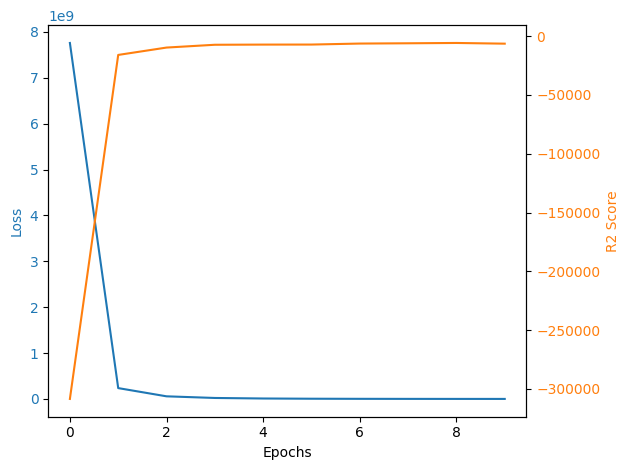

In [11]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Initialize model, loss function, and optimizer
model = ResNetWithAncillary(resnet).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Training loop
num_epochs = 10
train_losses = []
train_r2_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_outputs = []

    for images, ancillary_data, targets in train_loader:
        images = images.to(device)
        ancillary_data = ancillary_data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images, ancillary_data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        # Collecting outputs and labels for R2 score calculation
        all_labels.append(targets.detach().cpu().numpy())
        all_outputs.append(outputs.detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Calculate R2 score
    all_labels = np.vstack(all_labels)
    all_outputs = np.vstack(all_outputs)
    epoch_r2 = r2_score(all_labels, all_outputs, multioutput='uniform_average')
    train_r2_scores.append(epoch_r2)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, R2 Score: {epoch_r2:.4f}')


# Plotting the losses
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(train_losses, label='Training Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:orange')
ax2.plot(train_r2_scores, label='Training R2 Score', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.show()

In [65]:
torch.save(model.state_dict(), "model.pth")

# Convert to output

In [12]:
model.to(device)
model.eval()
predictions = []
image_ids = []

with torch.no_grad():
    for images, ancillary_data in test_loader:
        images = images.to(device)
        ancillary_data = ancillary_data.to(device)

        outputs = model(images, ancillary_data)
        predictions.extend(outputs.cpu().numpy())

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, columns=['X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
predictions_df.insert(0, 'id', test_df['id'])  # Insert the 'id' column from test.csv

# Save to CSV
predictions_df.to_csv('submission.csv', index=False)
